In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tssb.utils import load_time_series_segmentation_datasets
from tssb.evaluation import covering

In [3]:
# loading datasets
tssb = load_time_series_segmentation_datasets(names=["ArrowHead", "InlineSkate", "Plane"])

In [4]:
tssb

,dataset,window_size,change_points,time_series
0,ArrowHead,10,[753],"[-1.957721, -1.858082, -1.657983, -1.420794, -..."
1,InlineSkate,10,"[1058, 2704]","[-0.382758, -0.397053, -0.445415, -0.507809, -..."
2,Plane,10,"[540, 1044, 1368, 1944, 2412, 3060]","[2.195044, 1.409444, 0.570219, -0.17921, -0.87..."


In [20]:
arrow_ds = tssb.loc[tssb['dataset'] == 'ArrowHead']
arrow_ts = arrow_ds['time_series'][0]
arrow_chp = arrow_ds['change_points'][0]


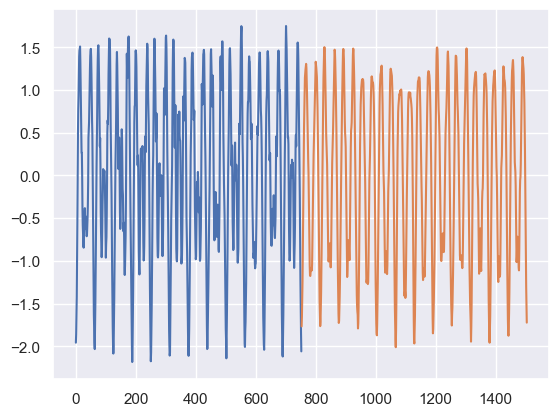

In [24]:
cur_idx = 0
for i in range(len(arrow_chp)):
    plt.plot(np.arange(cur_idx,arrow_chp[i]), arrow_ts[cur_idx:arrow_chp[i]])
    cur_idx = arrow_chp[i]
plt.plot(np.arange(cur_idx,len(arrow_ts)-1), arrow_ts[cur_idx:len(arrow_ts)-1])
plt.show()